<h3 style="text-align: center;"><b>Сравнение известных архитектур нейросетей для решения задачи классификации MNIST</b></h3>








In [1]:
!export PATH=/Library/TeX/texbin:$PATH

In [2]:
import os

import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as tfs
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

sns.set(style="darkgrid", font_scale=1.4)

In [3]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, num_workers=8)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, num_workers=8)

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### LeNet

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(5 * 5 * 16, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.fl(x) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [5]:
def evaluate_model(model, test_dataloader):
    num = 0
    den = 0
    y_true = list()
    y_pred = list()
    y_pred_prob = list()
    f1_valid = .0
    for x, y in test_dataloader:
        with torch.no_grad():
            output = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y,
                return_dict=True
            )
            loss = output.loss
            
            num += len(x) * loss.item()
            den += len(x)
            
            y_pred.extend(torch.argmax(output.logits, 1).tolist())
            y_pred_prob.extend(softmax(output.logits, dim = 1)[:, 1].tolist())
            y_true.extend(torch.argmax(y, 1).tolist())
            
    val_loss = num / den
    f1_valid = f1_score(y_true, y_pred, average = 'micro')
    return val_loss, f1_valid, y_pred_prob

In [9]:
def train_loop(
    model, loaders, 
    max_epochs=, 
    lr=1e-2,
    #eval_steps = 50
):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
    
    accuracy = {"train": [], "valid": []}
    
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)    
                preds = outp.argmax(-1)
                correct = preds[preds == y_batch]
                all_ = y_batch.shape[0]
                epoch_correct += correct.count_nonzero()
                epoch_all += all_  
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
        scheduler.step()
    return accuracy

In [10]:
model = LeNet()
criterion = nn.CrossEntropyLoss()
lenet_accuracy = train_loop(model, loaders)

Epoch: 1
Loader: train. Accuracy: 0.8480902910232544
Loader: valid. Accuracy: 0.8829126358032227
Epoch: 2
Loader: train. Accuracy: 0.8826789259910583
Loader: valid. Accuracy: 0.8842147588729858
Epoch: 3
Loader: train. Accuracy: 0.8866186141967773
Loader: valid. Accuracy: 0.8828125
Epoch: 4
Loader: train. Accuracy: 0.8933460116386414
Loader: valid. Accuracy: 0.8870192170143127
Epoch: 5
Loader: train. Accuracy: 0.8958666920661926
Loader: valid. Accuracy: 0.8900240659713745


In [14]:
lenet_accuracy

[tensor(0.8829),
 tensor(0.8842),
 tensor(0.8828),
 tensor(0.8870),
 tensor(0.8900)]

Сравним с предыдущем пунктом

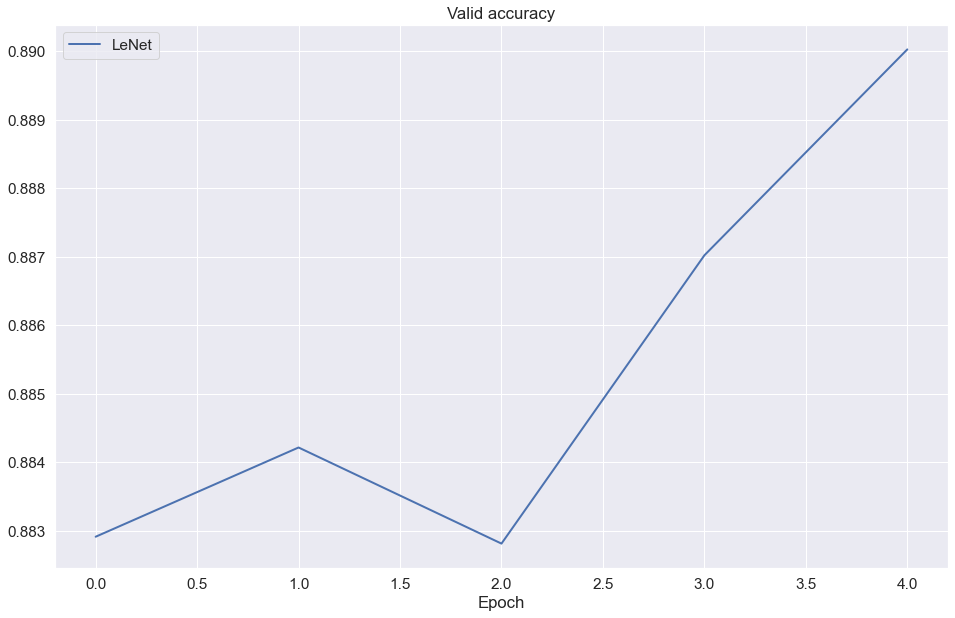

In [15]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(5), lenet_accuracy['valid'], label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()